In [46]:
import scipy.io as sio
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,Normalizer,QuantileTransformer
from keras.models import Model
from keras.layers import Dense,Input
import keras.backend as K
from keras.optimizers import *
from keras.layers import Lambda,Dropout,Embedding
from keras.utils import multi_gpu_model
from keras import regularizers
from IPython.display import SVG
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score
from sklearn import metrics
from keras.utils.vis_utils import model_to_dot
import os
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
from sklearn.manifold import TSNE,Isomap,LocallyLinearEmbedding
import umap
import matplotlib
from sklearn.cluster import *
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial import distance_matrix
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# data_mat = sio.loadmat('/home/yzy/SIMS/0801liver_data.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_0614_2.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_hunyang14_0827.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_0911_withlabel.mat')
data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_zuzhi_0918.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_0925.mat')


# data_mat = sio.loadmat('/home/yzy/SIMS/0713liver_data.mat')

data_mat=data_mat['data_mat']

num_features = 286
# num_features = 274
img_size = 256

def reset_weights(model):
    session = K.get_session()
#     k=0
    for layer in model.layers: 
#         print(k)
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
#             k+=1

def label2CM(label):
    label_sz = label.shape[0]
    rst = np.zeros(shape=(label_sz,label_sz))
    for i in range(label_sz):
        for j in range(i+1):
            if label[i]==label[j]:
                rst[i,j] = 1
                rst[j,i] = 1
    return rst
            
def get_matter_img(matter_idx,batch_num):
    data = batch_dict[batch_num]
    pos = pos_dict[batch_num]
    sorted_idx = np.argsort(pos)
    sorted_data = data[sorted_idx,matter_idx]
    return sorted_data.reshape((256,256))

def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]

def cal_square_dist(idx1,idx2,size):
    i1,j1=divmod(idx1-1,size)
    i1 +=1
    j1 +=1
    i2,j2=divmod(idx2-1,size)
    i2+=1
    j2+=1
    return (i1-i2)**2+(j1-j2)**2
def get_labeling(label,cell_idx):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b
    
    return labeling

In [12]:
np.unique(data_mat[:,3])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int32)

In [2]:
# 有label的情况

def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]

def cal_square_dist(idx1,idx2,size):
    i1,j1=divmod(idx1-1,size)
    i1 +=1
    j1 +=1
    i2,j2=divmod(idx2-1,size)
    i2+=1
    j2+=1
    return (i1-i2)**2+(j1-j2)**2


def get_graph_mat(cell_idx):
#     cell_idx表每个pixel属于哪个,cell_idx只取细胞相关的
    pixel_num = cell_idx.shape[0]
    graph_mat = np.ones(shape=(pixel_num,pixel_num))
    for i in range(pixel_num):
        for j in range(pixel_num):
            if(cell_idx[i]!=cell_idx[j]):
                graph_mat[i,j] = 0
    return graph_mat

def get_graph_mat_1(cell_pos,neighborhood=4):
    pixel_num = cell_pos.shape[0]
    graph_mat = np.zeros(shape=(pixel_num,pixel_num))
    if(neighborhood==4):
        for i in range(pixel_num):
            for j in range(pixel_num):
                i_pos = [ind2ij(i,256,0),ind2ij(i,256,1)]
                j_pos = [ind2ij(j,256,0),ind2ij(j,256,1)]
                if(abs(i_pos[0]-j_pos[0])+abs(i_pos[1]-j_pos[1])<=1):
                    graph_mat[i,j] = 1
    elif(neighborhood==8):
        for i in range(pixel_num):
            for j in range(pixel_num):
                i_pos = [ind2ij(i,256,0),ind2ij(i,256,1)]
                j_pos = [ind2ij(j,256,0),ind2ij(j,256,1)]
                if(abs(i_pos[0]-j_pos[0])<=1 and abs(i_pos[1]-j_pos[1])<=1):
                    graph_mat[i,j] = 1
    else:
        print('必须选4或者8')
        return False
    return graph_mat


from sklearn.metrics.pairwise import euclidean_distances
import pickle
batch_dict = {}
batch_dict_robust = {}
batch_dict_minmax = {}
batch_dict_standard = {}
batch_dict_134 = {}
batch_dict_norm = {}
batch_dict_norm_standard = {}
batch_dict_standard_norm = {}
label_dict = {}
cell_dict = {}
pos_dict = {}
cell_weight_dict = {}
FE_dict={}
for i in range(3):
    print(i)
    cur_data = data_mat[data_mat[:,0]==i+1,4:num_features+4]
    cur_data_134 = cur_data/cur_data[:,96-2][:,None]
    cur_data_robust = RobustScaler().fit_transform(cur_data)
    cur_data_minmax = MinMaxScaler().fit_transform(cur_data)
    cur_data_standard = StandardScaler().fit_transform(cur_data)
    cur_data_norm = Normalizer().fit_transform(cur_data)
    cur_data_norm_standard = StandardScaler().fit_transform(cur_data_norm)
    cur_data_standard_norm = Normalizer().fit_transform(cur_data_standard)
    batch_dict[i+1] = cur_data
    batch_dict_134[i+1] = cur_data_134
    batch_dict_robust[i+1] = cur_data_robust
    batch_dict_minmax[i+1] = cur_data_minmax
    batch_dict_standard[i+1] = cur_data_standard
    batch_dict_norm[i+1] = cur_data_norm
    batch_dict_norm_standard[i+1] = cur_data_norm_standard
    batch_dict_standard_norm[i+1] = cur_data_standard_norm
    label_dict[i+1] = data_mat[data_mat[:,0]==i+1,2]
    cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
    cur_batch_idx = data_mat[data_mat[:,0]==i+1,3]
#     FE_dict[i+1] = data_mat[data_mat[:,0]==i+1,4]
    pos_dict[i+1] = cur_batch_idx
#     cur_length = cur_data.shape[0]
#     cur_dist = np.zeros(shape=(cur_length,cur_length))
#     cur_ij_mat = np.zeros(shape=(cur_length,2))
#     for j in range(cur_length):
        
#         ii,jj=ind2ij(cur_batch_idx[j],img_size)
        
#         cur_ij_mat[j,0] = ii
#         cur_ij_mat[j,1] = jj
#     cur_dist = euclidean_distances(cur_ij_mat)
    
#     dist_dict[i+1] = cur_dist
# pickle.dump(dist_dict,open("/home/yzy/SIMS/eu_dist_dict_13.pkl","wb"))

0


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: divide by zero encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:70: RuntimeWarning: invalid value encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13


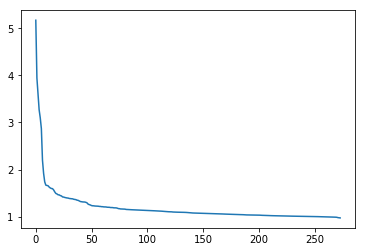

In [3]:
# 有label情况的处理

# 1.147 0.025
batch_num_list = [1]
# 5不行
# 1,2,3,4,5,6
# batch_num = 4
top_n_var = 250
train_x_all = None
cell_idx_all = None
cell_type_all = None
cell_pos_all = None
batch_idx_all = None
num_cells_all = 0


for batch_num in batch_num_list:
    train_x = batch_dict[batch_num]
    # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
    # train_x = batch_dict[batch_num]
    cell_idx = cell_dict[batch_num]
    cell_type = label_dict[batch_num]
    cell_pos = pos_dict[batch_num]
    # batch_FE = FE_dict[batch_num]
    cell_related_ind = (cell_idx!=0)

    num_cells = int(np.max(cell_idx))
    # num_cells = 2
    train_x = train_x[cell_related_ind,:]

    cell_idx = cell_idx[cell_related_ind]
    cell_type = cell_type[cell_related_ind]
    # cell_type = np.ones(shape=cell_idx.shape)
    cell_pos = cell_pos[cell_related_ind]





    var_li = []
    normed_var_li = []
    for i in range(train_x.shape[1]):
        cur_col = train_x[:,i]
    #     cur_col= cur_row/np.sum(cur_col)
    #     cur_entropy = entropy(cur_col)
        cur_var = np.var(cur_col)
        cur_normed_var = cur_var/np.mean(cur_col)
    #     entropy_li.append(cur_entropy)
        var_li.append(cur_var)
        normed_var_li.append(cur_normed_var)
    # entropy_li = np.array(entropy_li)
    var_li = np.array(var_li)
    normed_var_li = np.array(normed_var_li)
    sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
    sort_val = np.flip(np.sort(normed_var_li),axis=0)
    plt.plot(sort_val)
    plt.show()


    train_x = train_x/np.percentile(train_x,80,axis=1,keepdims=True)
    train_x = np.log(train_x+1)
    
    
    if train_x_all is None:
        train_x_all = train_x
    else:
        train_x_all = np.vstack([train_x_all,train_x])
    if cell_idx_all is None:
        cell_idx_all = cell_idx
    else:
        cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
    if cell_type_all is None:
        cell_type_all = cell_type
    else:
        cell_type_all = np.hstack([cell_type_all,cell_type])
    if cell_pos_all is None:
        cell_pos_all = cell_pos
    else:
        cell_pos_all = np.hstack([cell_pos_all,cell_pos])
    if batch_idx_all is None:
        batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
    else:
        batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])
    

train_x = train_x_all
cell_idx = cell_idx_all
cell_type = cell_type_all
cell_pos = cell_pos_all
batch_idx = batch_idx_all
num_cells = np.max(cell_idx)
train_x = StandardScaler().fit_transform(train_x)


In [30]:
# 无label的情况
from sklearn.metrics.pairwise import euclidean_distances
import pickle
batch_dict = {}
batch_dict_robust = {}
batch_dict_minmax = {}
batch_dict_standard = {}
batch_dict_134 = {}
batch_dict_norm = {}
batch_dict_norm_standard = {}
batch_dict_standard_norm = {}
label_dict = {}
cell_dict = {}
pos_dict = {}
cell_weight_dict = {}
FE_dict={}
for i in range(3):
    print(i)
    cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]
#     cur_data_134 = cur_data/cur_data[:,91][:,None]
#     cur_data_134 = cur_data/cur_data[:,96-2][:,None]
    cur_data_134 = cur_data/cur_data[:,93-2][:,None]

    cur_data_robust = RobustScaler().fit_transform(cur_data)
    cur_data_minmax = MinMaxScaler().fit_transform(cur_data)
    cur_data_standard = StandardScaler().fit_transform(cur_data)
    cur_data_norm = Normalizer().fit_transform(cur_data)
    cur_data_norm_standard = StandardScaler().fit_transform(cur_data_norm)
    cur_data_standard_norm = Normalizer().fit_transform(cur_data_standard)
    batch_dict[i+1] = cur_data
    batch_dict_134[i+1] = cur_data_134
    batch_dict_robust[i+1] = cur_data_robust
    batch_dict_minmax[i+1] = cur_data_minmax
    batch_dict_standard[i+1] = cur_data_standard
    batch_dict_norm[i+1] = cur_data_norm
    batch_dict_norm_standard[i+1] = cur_data_norm_standard
    batch_dict_standard_norm[i+1] = cur_data_standard_norm
    cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
    cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
    label_dict[i+1] = np.zeros(shape=cur_batch_idx.shape)
    label_dict[i+1][cell_dict[i+1]!=0]=1
    
   
    pos_dict[i+1] = cur_batch_idx

0


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


1
2


In [29]:
cur_batch_idx

array([    1,     2,     3, ..., 65304, 65305, 65306], dtype=int32)

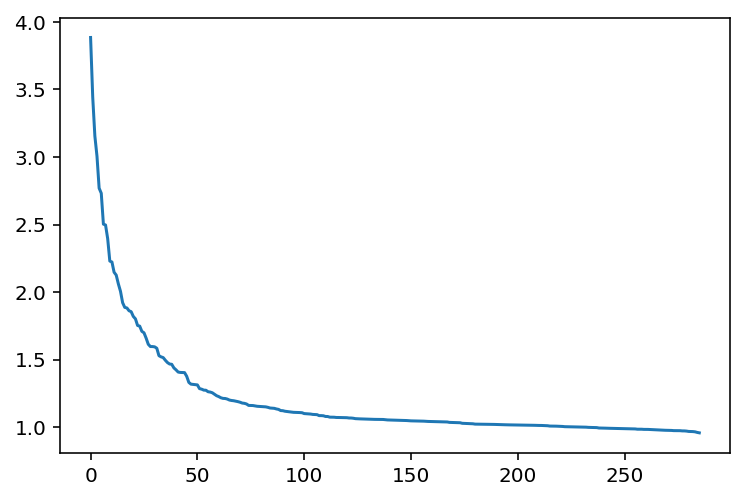

In [38]:
# 有label情况的处理

# 1.147 0.025
batch_num_list = [3]
# 5行
# 1,2,3,4,5,6
# batch_num = 4
top_n_var = 250
train_x_all = None
cell_idx_all = None
cell_type_all = None
cell_pos_all = None
batch_idx_all = None
num_cells_all = 0


for batch_num in batch_num_list:
    train_x = batch_dict[batch_num]
    # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
    # train_x = batch_dict[batch_num]
    cell_idx = cell_dict[batch_num]
    cell_type = label_dict[batch_num]
    cell_pos = pos_dict[batch_num]
    # batch_FE = FE_dict[batch_num]
    cell_related_ind = (cell_idx!=0)

    num_cells = int(np.max(cell_idx))
    # num_cells = 2
    train_x = train_x[cell_related_ind,:]

    cell_idx = cell_idx[cell_related_ind]
    cell_type = cell_type[cell_related_ind]
    # cell_type = np.ones(shape=cell_idx.shape)
    cell_pos = cell_pos[cell_related_ind]





    var_li = []
    normed_var_li = []
    for i in range(train_x.shape[1]):
        cur_col = train_x[:,i]
    #     cur_col= cur_row/np.sum(cur_col)
    #     cur_entropy = entropy(cur_col)
        cur_var = np.var(cur_col)
        cur_normed_var = cur_var/np.mean(cur_col)
    #     entropy_li.append(cur_entropy)
        var_li.append(cur_var)
        normed_var_li.append(cur_normed_var)
    # entropy_li = np.array(entropy_li)
    var_li = np.array(var_li)
    normed_var_li = np.array(normed_var_li)
    sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
    sort_val = np.flip(np.sort(normed_var_li),axis=0)
    plt.plot(sort_val)
    plt.show()


    train_x = train_x/np.percentile(train_x,80,axis=1,keepdims=True)
    train_x = np.log(train_x+1)
    
    
    if train_x_all is None:
        train_x_all = train_x
    else:
        train_x_all = np.vstack([train_x_all,train_x])
    if cell_idx_all is None:
        cell_idx_all = cell_idx
    else:
        cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
    if cell_type_all is None:
        cell_type_all = cell_type
    else:
        cell_type_all = np.hstack([cell_type_all,cell_type])
    if cell_pos_all is None:
        cell_pos_all = cell_pos
    else:
        cell_pos_all = np.hstack([cell_pos_all,cell_pos])
    if batch_idx_all is None:
        batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
    else:
        batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])
    

train_x = train_x_all
cell_idx = cell_idx_all
cell_type = cell_type_all
cell_pos = cell_pos_all
batch_idx = batch_idx_all
num_cells = np.max(cell_idx)
train_x = StandardScaler().fit_transform(train_x)



In [5]:
br_sample = sio.loadmat('/home/yzy/SIMS/468br_skno_br.mat')
br_sample = br_sample['br_sample']

In [40]:
batch_num = 3
idx_func = np.vectorize(ind2ij)
cell_median_list = []
for i in range(num_cells):
    cur_cell_pos = pos_dict[batch_num][cell_dict[batch_num]==i+1]
    median_i = int(np.median(idx_func(cur_cell_pos,256,0)))
    median_j = int(np.median(idx_func(cur_cell_pos,256,1)))
    cell_median_list.append([median_i,median_j])
cell_median_list = np.array(cell_median_list)-1

In [47]:
tri_1=matplotlib.tri.Triangulation(cell_median_list[:,0],cell_median_list[:,1])

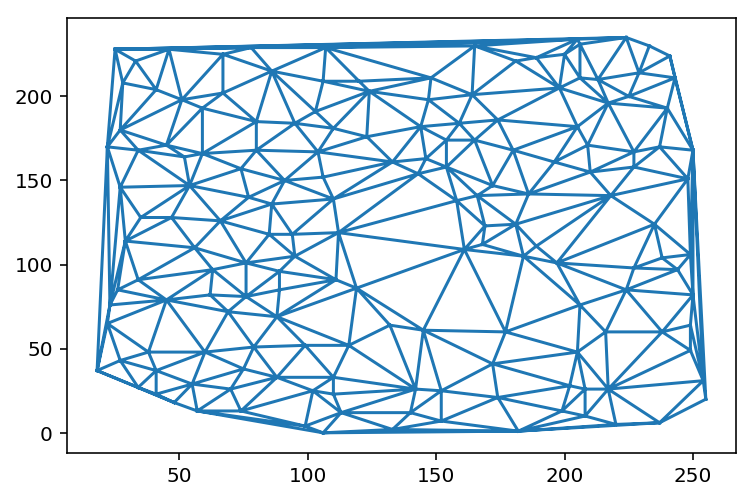

In [48]:
plt.triplot(tri_1)

In [50]:
edge_mat = np.zeros(shape=(num_cells,num_cells))
for i in range(tri_1.edges.shape[0]):
    edge_mat[tri_1.edges[i,0],tri_1.edges[i,1]] = 1
    edge_mat[tri_1.edges[i,1],tri_1.edges[i,0]] = 1


In [55]:
edge_mat[0,30]

0.0

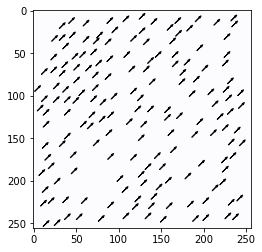

In [16]:
labeled_img = label_dict[batch_num][np.argsort(pos_dict[batch_num])]
labeled_img = labeled_img.reshape((256,256))
plt.imshow(labeled_img,cmap='Purples')
for i in range(num_cells):
#     for j in range(1):
#         if i==j:
#             continue
        
#     plt.arrow(cell_median_list[i,1],cell_median_list[i,0],np.abs(cell_median_list[i,1]-cell_median_list[j,1]),np.abs(cell_median_list[i,0]-cell_median_list[j,0]),head_width=2)
    plt.arrow(cell_median_list[i,1],cell_median_list[i,0],5,-5,head_width=2)

plt.show()

In [57]:
matter_mean_list = []
target_matter = batch_dict[batch_num][:,217]
for i in range(num_cells):
    cur_cell_intensity = np.mean(target_matter[cell_dict[batch_num]==i+1])
    matter_mean_list.append(cur_cell_intensity)
matter_mean_list = np.array(matter_mean_list)

In [58]:
distance_mat = distance_matrix(cell_median_list,cell_median_list)
intensity_diff_mat = np.zeros(shape=(num_cells,num_cells))
for i in range(num_cells):
    cur_matter_intensity = matter_mean_list[i]
    neighbor_matter_intensity = cur_matter_intensity - matter_mean_list
    intensity_diff_mat[i,:] = neighbor_matter_intensity
    

In [31]:
np.unique(label_dict[1])

array([ 0.,  1.])

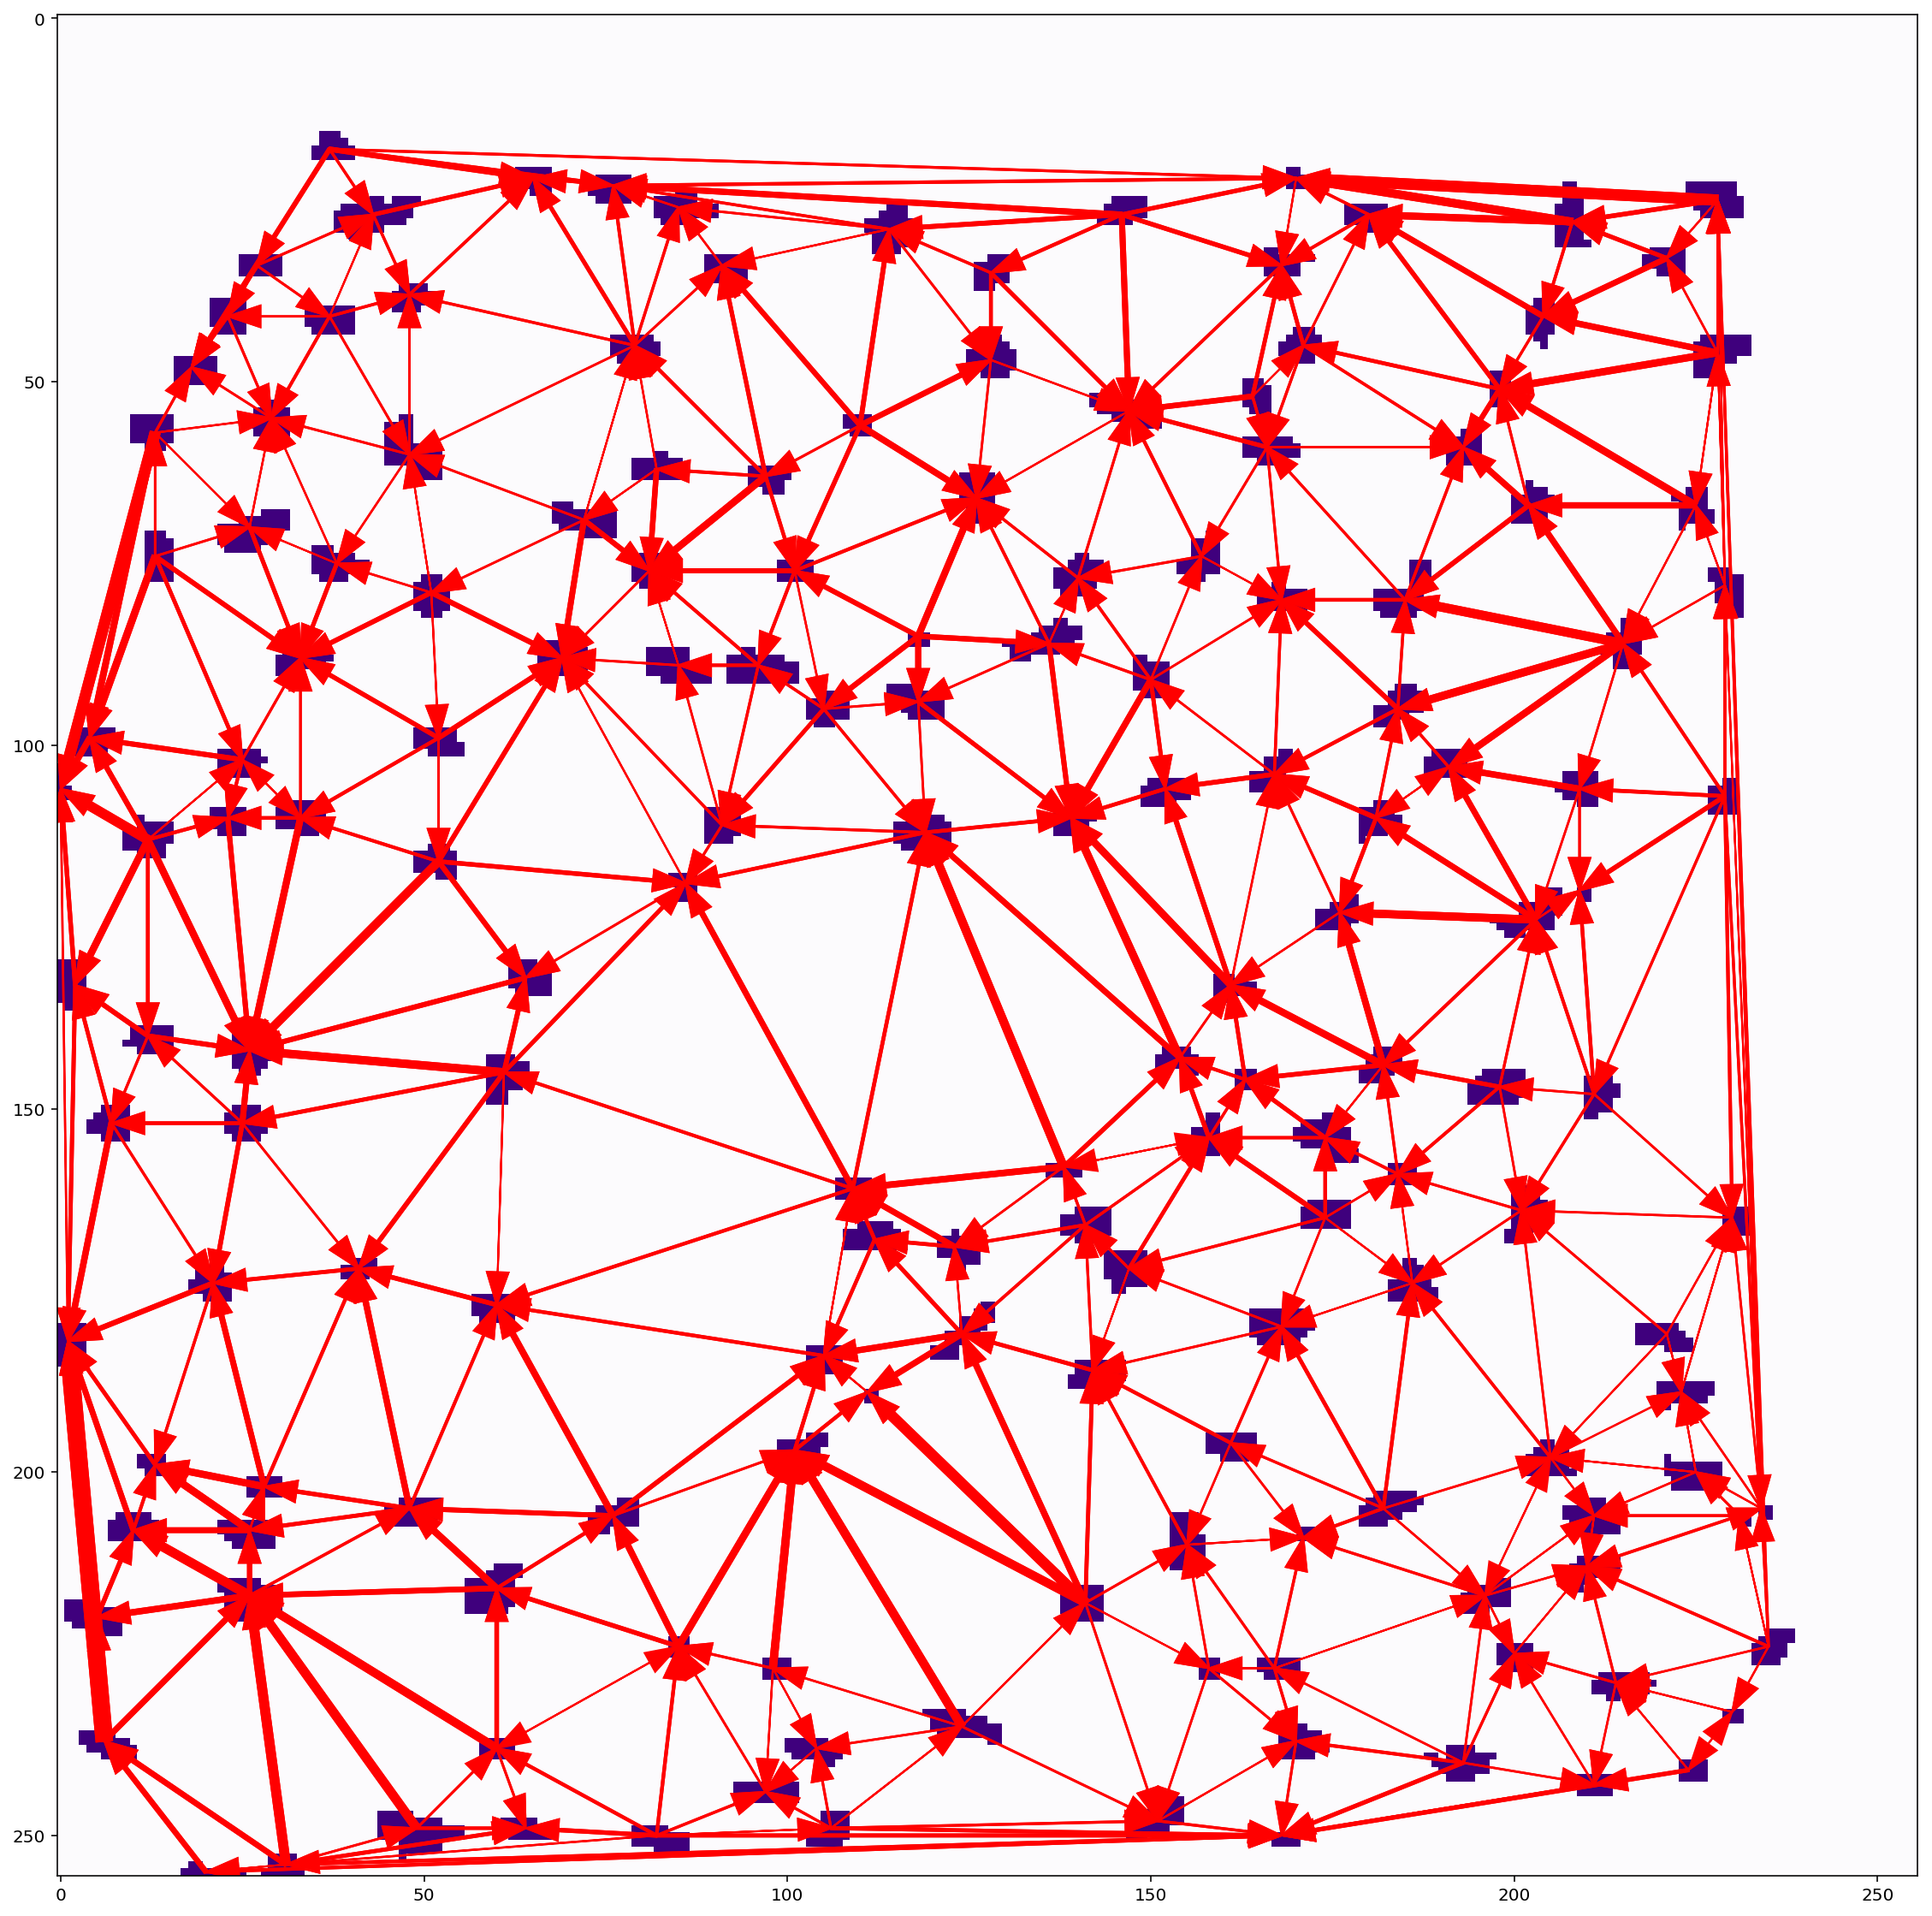

In [60]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# X = csr_matrix()
# Tcsr = minimum_spanning_tree(X)
# Tcsr.toarray().astype(int)

distance_threshold = 20
k_neighbors = 5
arrow_mini_gap = 1
labeled_img = label_dict[batch_num][np.argsort(pos_dict[batch_num])]
labeled_img = labeled_img.reshape((256,256))
fig = plt.figure(figsize=(20,20))
plt.imshow(labeled_img,cmap='Purples')
for i in range(num_cells):
    cur_distance_row = distance_mat[i,:]
#     selected_neighbors = (cur_distance_row<=distance_threshold)
#     selected_neighbors = (Tcsr[i,:]>0)
    
#     selected_neighbors = np.zeros(shape=(num_cells,))
#     selected_neighbors[np.argsort(cur_distance_row)[0:k_neighbors]] = 1
    
#     selected_neighbors[i] = False
    selected_neighbors = edge_mat[i,:]
    for j in range(num_cells):
        if selected_neighbors[j]==False:
            continue
        line_width = 3*np.abs(intensity_diff_mat[i,j])/np.max(np.abs(intensity_diff_mat))
#         print(line_width)
        if intensity_diff_mat[i,j]>0:
            
#             plt.arrow(cell_median_list[j,1],cell_median_list[j,1],np.abs(cell_median_list[j,0]-cell_median_list[i,0]),np.abs(cell_median_list[j,1]-cell_median_list[i,1]),head_width=2)
            plt.arrow(cell_median_list[j,1],cell_median_list[j,0],-(cell_median_list[j,1]-cell_median_list[i,1]),-(cell_median_list[j,0]-cell_median_list[i,0]),head_width=3,length_includes_head=True,width=line_width,color='red')
            
        else:
#             plt.arrow(cell_median_list[i,0],cell_median_list[i,1],np.abs(cell_median_list[j,0]-cell_median_list[i,0]),np.abs(cell_median_list[j,1]-cell_median_list[i,1]),head_width=2)
            plt.arrow(cell_median_list[i,1],cell_median_list[i,0],-(cell_median_list[i,1]-cell_median_list[j,1]),-(cell_median_list[i,0]-cell_median_list[j,0]),head_width=3,length_includes_head=True,width=line_width,color='red')
            
plt.show()

In [94]:
X = csr_matrix(distance_mat)
Tcsr = minimum_spanning_tree(X)
Tcsr = Tcsr.toarray()

In [101]:
selected_neighbors

array([ 0.,  0.,  0.])

In [117]:
1+1

2

In [118]:
import seaborn as sns

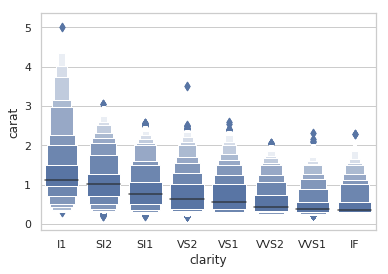

In [7]:
import seaborn as sns
import ssl
# sns.set()
ssl._create_default_https_context = ssl._create_unverified_context

sns.set(style="whitegrid")

diamonds = sns.load_dataset("diamonds")
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

sns.boxenplot(x="clarity", y="carat",
              color="b", order=clarity_ranking,
              scale="linear", data=diamonds)
plt.show()

In [8]:
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


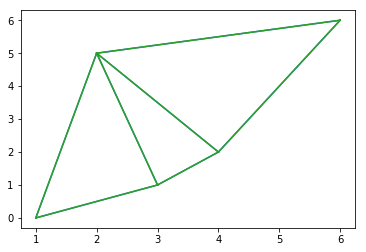

In [4]:

x = np.array([1,2,3,6,4])
y = np.array([0,5,1,6,2])
plt.triplot(x,y)
plt.show()